# run_ms_analysis.ipynb
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder.

# Required mcce run output files:
### 1. head3.lst
### 2. file in ms_out/, a.k.a. the 'msout file'
 * Notes:
   - The ms_out folder is retained when the `--ms` flag is used at the command line for Step 4: `step4.py --ms`;
   - Format of the msout file name: pHXeHYms.tx at pH point X and Eh point Y;
   - The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.

# Required user input: the path to the msout file:
 * e.g. 4lzt/ms_out/pH7eH0ms.txt
# Optional user input: list of residues of interest

## Load the needed libraries and modules:

In [1]:
#also note that the python modules ms_analysis.py and weighted_correlation. py should be in the running directory
#an output directory will be made and will contain csv and pdf files


In [2]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import os

%matplotlib inline

# Module needed to read the microstate file:
import ms_analysis as msa
import weighted_correlation as wc

In [3]:
#Move the definiation of residue types of interst and individual residues of interest here at the top
#threshold for the heat maps; lables for plots
#if we dont do all 6 blocks of Microstates
#

# Define the path to msout file:

In [4]:
msout_file = "ms_out/pH7eH0ms.txt"

# Instantiate `msa.MSout` class with the given msout file:

In [5]:
mc = msa.MSout(msout_file)

print(f"Microstates count: {mc.N_ms:,}")
print(f"Unique microstates count: {mc.N_uniq:,}")

Microstates count: 1,500,000
Unique microstates count: 394,139


In [6]:
##We need this informations in a logfile as output:
##Microstates count: 1,500,000
##Unique microstates count: 394,139

[ optional ]
#### What's in this class?

#### The following saves microstates attributes (energy, count and microstate state) into a list, which is then sorted by enthalpy, descendingly.

In [7]:
#The ms_orig_lst gives one conformer for each residues.  It is the initial state for MC sampling.
#The conformer numbers align with head3.lst.  Head3.lst starts at 1; ms lists start at 0.
#The first number is the microstate energy; the second is the MC restart (default 6 times)
ms_orig_lst = [[ms.E, ms.count, ms.state] for  ms in list((mc.microstates.values()))]
ms_orig_lst = sorted(ms_orig_lst, key = lambda x:x[0])
print(ms_orig_lst[:2]) 

[[-184.972214, 7, [0, 7, 33, 41, 44, 50, 54, 57, 71, 75, 79, 81, 83, 86, 92, 95, 101, 108, 120, 127, 136, 150, 154, 163, 169, 174, 177, 185, 191, 193, 205, 211, 215, 218, 227, 236, 242, 245, 268, 272, 278, 281, 287, 290, 297, 302, 313]], [-184.947266, 36, [0, 7, 33, 41, 44, 50, 54, 57, 71, 75, 79, 81, 83, 86, 92, 95, 101, 108, 120, 127, 136, 150, 154, 163, 169, 175, 177, 185, 191, 193, 205, 211, 215, 218, 227, 236, 242, 245, 268, 272, 278, 281, 287, 290, 297, 302, 313]]]


In [8]:
## I don't think so we need this in the output log file

### In MCCE, residues are divided into fixed or free residue groups.
 * Only free residues appear in the microstate sate list.
 * Fixed residues can be ionizable residues so we need to include their contribution to the total charge, which is called referred to here as __background charge__. 

#### Free residues information

In [9]:
free_residues = []
for res in mc.free_residues:
    free_residues.append(msa.conformers[res[1]].resid)
ms_free_residues = pd.DataFrame(free_residues,columns = ["Residue"])
print(f"Number of free residues: {ms_free_residues.shape[0]:,}")
ms_free_residues.head(3)
ms_free_residues.tail(3)

Number of free residues: 47


,Residue
44,HOHA1015_
45,HOHA1016_
46,HOHA1073_


In [10]:
##Print the 'Number of free residues: 47' in the output logfile
##maybe have a print to csv file commented out so peopel can turn it on (?)

#### Fixed residues charge.
(Make sure to account for fixed residues charge for MD simulation protonation input.)

In [11]:
fixed_res_crg_dict = defaultdict(float)
for conf in msa.conformers:
    if conf.iconf in mc.fixed_iconfs:
        fixed_res_crg_dict[conf.resid] = conf.crg

background_charge = sum(fixed_res_crg_dict.values())
print("Background charge:", background_charge)

Background charge: 8.0


In [12]:
##From here just print the 'Background charge: 8.0' in the output logfile

# Residues of interest
Note: Make sure to add the names of your residues of interest, such as quinone, here:

In [13]:
res_of_interest = ["ASP", "PL9", "GLU", "ARG", "HIS", "LYS", "TYR", "NTR", "CTR"]

In [14]:
#Types of residues of interest.  you can add titratable ligands here

### Save the fixed residues in your residues of interest to list:

In [15]:
fixed_res_of_interest = {k:v for k,v in fixed_res_crg_dict.items() if k[:3] in res_of_interest}

#fixed_residues_crg = pd.DataFrame.from_dict(fixed_res_of_interest, orient='index', columns=['Residue', 'crg'])
fixed_residues_crg = pd.DataFrame(fixed_res_of_interest.items(), columns=['Residue', 'crg'])

print(f"Number of fixed residues from residues of interest: {fixed_residues_crg.shape[0]:,}")
fixed_residues_crg

Number of fixed residues from residues of interest: 25


,Residue,crg
0,ARGA0005_,1.0
1,GLUA0007_,-1.0
2,LYSA0013_,1.0
3,ARGA0014_,1.0
4,ASPA0018_,-1.0
5,ARGA0021_,1.0
6,LYSA0033_,1.0
7,ARGA0045_,1.0
8,ASPA0048_,-1.0
9,ASPA0052_,-1.0


In [16]:
##print 'Number of fixed residues from residues of interest: 25' in the log file, 
##Print these residues and their charges in a simple 3colum csv file

### This will convert the microstate conformer id to corresponding charge.

In [17]:
def convert_ms_crg(l, d):
    crg_lst =[[y[0], y[1], [convert_ms_crg(x, d) if isinstance(x, list) else d.get(x, x) for x in y[2]]] for y in l]
    
    return crg_lst

In [18]:
# Map conf index to conf charge:
# These arrays are identical to ms_orig_lst but now simply give the charge of the coformers selected for each residue.
id_vs_charge = {conf.iconf:conf.crg for conf in msa.conformers}

crg_orig_lst = convert_ms_crg(ms_orig_lst, id_vs_charge)
print(crg_orig_lst[:2])

[[-184.972214, 7, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [-184.947266, 36, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


In [19]:
## Don't need to print this things

## Function `findUniqueCrgmsCountOrder` will give the unique charge state id, corresponding count.

In [20]:
def findUniqueCrgmsCountOrder(crg_list_ms: list, begin_energy: float = None, end_energy: float = None):
    """You need the charge  microstate list (crg_orig_lst) here. Make sure
    the crg file is sorted with increasing order. If you want to filter 
    charge id based on the energy. Then you need to supply here.
    
    Variable unique_crg_state_order gives the order of unique charge state based on energy. 
    Lowest energy charge state will give the order 1 and then second unique charge 
    state will give the order 2. This order is based on unique charge ms order.
    
    Returns:
     A tuple of lists: all_crg_ms_unique, all_count, unique_crg_state_order, energy_diff_all
    """
    if not begin_energy and not end_energy:
        # no energy bounds given
        print("All energy microstates are selected.")
        begin_energy = crg_list_ms[0][0]
        end_energy = crg_list_ms[-1][0]
    elif begin_energy and end_energy:
        # both energy bounds given
        crg_list_ms = [[x[0], x[1], x[2]] for x in crg_list_ms if x[0] >= begin_energy and x[0] <= end_energy]   
    else:
        sys.exit("Both energy bounds are needed.")
        
    # unique charge as key and energy, count and order
    crg_all_count = {}
    unique_crg_state_order = 1
    for array in crg_list_ms:
        if tuple(array[2]) not in crg_all_count:
            crg_all_count[(tuple(array[2]))] = [array[1], [array[0]], [unique_crg_state_order]]
            unique_crg_state_order +=1
        else:
            crg_all_count[(tuple(array[2]))][0] += array[1]

            # add the maximum and minimum energy 
            min_energy = min(min(crg_all_count[(tuple(array[2]))][1]), array[0]) 
            max_energy = max(max(crg_all_count[(tuple(array[2]))][1]), array[0])

            # clear energy list and append minimum and maximum energy
            crg_all_count[(tuple(array[2]))][1].clear()
            crg_all_count[(tuple(array[2]))][1].append(min_energy)
            crg_all_count[(tuple(array[2]))][1].append(max_energy)

    # make a list of count, unique charge microstate, energy difference and order.
    all_crg_ms_unique  = []
    all_count = []
    energy_diff_all = []
    unique_crg_state_order = []
    for u, v in crg_all_count.items():
        all_crg_ms_unique.append(list(u))
        all_count.append(v[0])
        unique_crg_state_order.append(v[2][0])
        if len(v[1]) == 2:
            energy_diff_all.append(round(v[1][1]-v[1][0], 6))
        elif len(v[1]) == 1:
            energy_diff_all.append(0)
        else:
            sys.exit("Error while creating unique charge state: len(v[1]) is neither 1 or 2.")
    print(f"Number of charge ms: {len(crg_list_ms):,}")
    print(f"Number of unique charge ms: {len(all_crg_ms_unique)}")
    
    return all_crg_ms_unique, all_count, unique_crg_state_order, energy_diff_all 


def ConcaCrgMsPandas(unique_crg_ms_list, ms_count, ms_order, free_residues, background_charge, residue_interest_list):
    """
    """
    unique_crg_ms_list_pd = pd.DataFrame(unique_crg_ms_list).T
    ms_count_pd = pd.DataFrame(ms_count,columns = ["Count"]).T
    ms_order_pd = pd.DataFrame(ms_order,columns = ["Order"]).T
    crg_ms_count_pd = pd.concat([unique_crg_ms_list_pd, ms_count_pd, ms_order_pd])
    crg_count_res_1 = pd.concat([free_residues,crg_ms_count_pd], axis=1)
    crg_count_res_1.loc["Count", 'Residue'] = 'Count'
    crg_count_res_1.loc["Order", 'Residue'] = 'Order'
    all_crg_count_res = crg_count_res_1.set_index("Residue")
    
    # sort based on the count
    all_crg_count_res = all_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)
    all_crg_count_res.columns = range(all_crg_count_res.shape[1])
    all_crg_count_res = all_crg_count_res.T.set_index("Order")
    all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
    all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge
    crg_count_res = all_crg_count_res.copy()
    for i in all_crg_count_res.columns:
        if i[:3] not in residue_interest_list and i != "Occupancy" and i != "Count" and i != "Sum_crg_protein":
            crg_count_res.drop([i], axis = 1, inplace = True)

    return crg_count_res

## Select all energy microstate list

In [21]:
charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst)

all_crg_count_res = ConcaCrgMsPandas(charge_ms_file[0],
                                     charge_ms_file[1],
                                     charge_ms_file[2], 
                                     ms_free_residues,
                                     background_charge,
                                     res_of_interest
                                    )
all_crg_count_res.head() 

All energy microstates are selected.
Number of charge ms: 394,139
Number of unique charge ms: 15


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,TYRA0023_,GLUA0035_,ASPA0119_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,902236.0,0.601,7.0
2.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,545491.0,0.364,8.0
3.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,18153.0,0.012,8.0
4.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,11926.0,0.008,8.0
5.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,10356.0,0.007,9.0


In [22]:
##We just wan to print the following things from here:
##All energy microstates are selected.
##Number of charge ms: 394,139
##Number of unique charge ms: 15'

## Do not need to print the residues charge table

Figure saved successfully: output\all_en_cr_ph7_vs_log(count).pdf


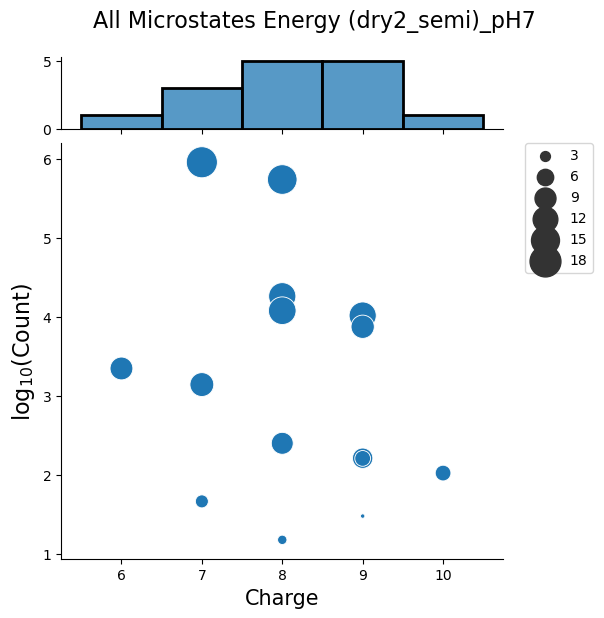

In [23]:
# Ensure 'output/' directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Compute charge state population including background charge
x_av = [sum(x) + background_charge for x in charge_ms_file[0]]

# Avoid log(0) by replacing zeros with NaN (or a small positive value)
y_av = [math.log10(x) if x > 0 else float('nan') for x in charge_ms_file[1]]

# Convert energy differences to float
energy_diff_all_fl = [float(x) for x in charge_ms_file[3]]

# Initialize the JointGrid
g1 = sns.JointGrid(marginal_ticks=True, height=6)

# Scatter plot with bubble sizes based on energy differences
ax = sns.scatterplot(
    x=x_av, 
    y=y_av, 
    size=energy_diff_all_fl, 
    sizes=(10, 500), 
    ax=g1.ax_joint
)

# Set x-axis ticks based on the range of x_av
ax.set_xticks(range(int(min(x_av)), int(max(x_av)) + 1))

# Labels
ax.set_xlabel("Charge", fontsize=15)
ax.set_ylabel(r"log$_{10}$(Count)", fontsize=16)

# Adjust legend position
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Histogram on the marginal x-axis
ax2 = sns.histplot(
    x=x_av, 
    linewidth=2, 
    discrete=True, 
    ax=g1.ax_marg_x
)
ax2.set_ylabel(None)

# Remove y-axis marginal plot
g1.ax_marg_y.set_axis_off()

# Adjust layout and title
g1.fig.subplots_adjust(top=0.9)
g1.fig.suptitle("All Microstates Energy (dry2_semi)_pH7", fontsize=16)

# Save the figure
mc_energy_fig = os.path.join(output_dir, "all_en_cr_ph7_vs_log(count).pdf")
g1.savefig(mc_energy_fig, dpi=600, bbox_inches="tight")

print(f"Figure saved successfully: {mc_energy_fig}")

### This will plot the  tautomer charge distribution of unqiue charge microstate based on the occupancy. Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

In [24]:
## A very important thing here in this dot plot we need to be clear what is these dots numbers mean?
## Infact we have a different type of output figure for this. I will share with you. I believe these values are eneergy range of the microstates,
## but the numbers sometimes do not make sense

#### This is to get the unique charge microstate less or equal to  lowest energy + 1.36 KCal/Mol. Make sure your supply list is sorted based on energy in ascending (?) order. The order shows in dataframe is here within the selected energy range.

In [25]:
lowest_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst,
                                                  begin_energy = crg_orig_lst[0][0],
                                                  end_energy = crg_orig_lst[0][0] + 1.36
                                                 )
low_crg_count_res = ConcaCrgMsPandas(lowest_charge_ms_file[0],
                                     lowest_charge_ms_file[1],
                                     lowest_charge_ms_file[2], 
                                     ms_free_residues,
                                     background_charge,
                                     res_of_interest)
low_crg_count_res.head() 

Number of charge ms: 2,198
Number of unique charge ms: 2


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,TYRA0023_,GLUA0035_,ASPA0119_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,9468.0,0.708,7.0
2.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,3903.0,0.292,8.0


In [26]:
## we just need to print into the log file:
#Number of charge ms: 2,198
#Number of unique charge ms: 2

#### This is to get the unique charge microstate around +/- 0.5 pH unit (+/- 0.68 Kcal/Mol) of average microstate energy. The order shows in dataframe is here within the selected energy range.

In [27]:
average_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst,
                                                   begin_energy = (mc.average_E - 0.68),
                                                   end_energy = (mc.average_E + 0.68)
                                                  )
av_crg_count_res = ConcaCrgMsPandas(average_charge_ms_file[0],
                                    average_charge_ms_file[1],
                                    average_charge_ms_file[2], 
                                    ms_free_residues,
                                    background_charge,
                                    res_of_interest
                                   )
av_crg_count_res.head() 

Number of charge ms: 93,790
Number of unique charge ms: 9


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,TYRA0023_,GLUA0035_,ASPA0119_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,
2.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,211761.0,0.599,7.0
1.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,133634.0,0.378,8.0
3.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,2965.0,0.008,8.0
4.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,1803.0,0.005,8.0
5.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,1621.0,0.005,9.0


In [28]:
## we just need to print into the log file:
##Number of charge ms: 93,790
##Number of unique charge ms: 9

### This is to get the unique charge microstate  of 1KT unit(1.36 Kcal/Mol) less or equal than highest energy state. The order shows in dataframe is here within the selected energy range.

In [29]:
highest_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst,
                                                   begin_energy = (mc.highest_E - 1.36),
                                                   end_energy = mc.highest_E
                                                  )
high_crg_count_res = ConcaCrgMsPandas(highest_charge_ms_file[0],
                                      highest_charge_ms_file[1],
                                      highest_charge_ms_file[2], 
                                      ms_free_residues,
                                      background_charge,
                                      res_of_interest)
high_crg_count_res.head()

Number of charge ms: 9
Number of unique charge ms: 3


Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,TYRA0023_,GLUA0035_,ASPA0119_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,11.0,0.478,7.0
3.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,10.0,0.435,8.0
2.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,2.0,0.087,9.0


In [30]:
## we just need to print into the log file:
#Number of charge ms: 9
#Number of unique charge ms: 3

### Save all the dataframes.

In [31]:
# save all three data frames and non titrable residues charge information.
##writer = pd.ExcelWriter('charge_ms_dry2_semi_pH7.xlsx', engine='xlsxwriter')
##low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
##av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
##high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
##fixed_residues_crg.to_excel(writer, sheet_name = 'fixed_residues_crg')
##writer.save()

In [32]:
# Assuming you have already defined low_crg_count_res, av_crg_count_res, high_crg_count_res, and fixed_residues_crg
outfile_xl = "output/charge_ms_dry2_semi_pH7.xlsx"
try:
    # Create an ExcelWriter object
    writer = pd.ExcelWriter(outfile_xl, engine='xlsxwriter')

    # Write your dataframes to different sheets
    low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
    av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
    high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
    fixed_residues_crg.to_excel(writer, sheet_name='fixed_residues_crg')

    # Save the Excel file
    writer.save()
    print(f"Excel file {outfile_xl!s} saved successfully.")

except Exception as e:
    print(f"Error occurred while saving Excel file: {str(e)}")


# Save another DataFrame to a CSV file
# Due to column size issue in excel for large sytem. We save in csv format for all charge.   
crg_count_csv = "output/all_crg_count_res.csv"

try:
    all_crg_count_res.to_csv(crg_count_csv, header=True)
    print(f"CSV file {crg_count_csv!s} saved successfully.")

except Exception as e:
    print(f"Error occurred while saving CSV file: {str(e)}")


Excel file output/charge_ms_dry2_semi_pH7.xlsx saved successfully.
CSV file output/all_crg_count_res.csv saved successfully.


C:\Users\Gazi Raihan\AppData\Local\Temp\ipykernel_19620\1794319098.py:14: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


---
# Post-processing of already saved files to get the correlation matrix for residues. 

In [33]:
# This is for correlation.
all_crg_count_read = pd.read_csv(crg_count_csv, index_col = 0)
all_crg_count =  all_crg_count_read.iloc[:,:-2].T
all_crg_count

Order,1.0,2.0,3.0,4.0,5.0,6.0,8.0,7.0,9.0,10.0,12.0,13.0,15.0,14.0,11.0
NTRA0001_,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
LYSA0001_,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
HISA0015_,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
TYRA0020_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TYRA0023_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLUA0035_,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0
ASPA0119_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0
Count,902236.0,545491.0,18153.0,11926.0,10356.0,7470.0,2214.0,1385.0,250.0,162.0,161.0,105.0,46.0,30.0,15.0


In [34]:
# drop if the protonation is not changing in free residues
all_crg_count["std"] = all_crg_count.std(axis=1).round(2)
all_crg_count_std = all_crg_count.loc[all_crg_count['std'] != 0].T[:-1].reset_index(drop=True)
all_crg_count_std

,NTRA0001_,LYSA0001_,HISA0015_,GLUA0035_,ASPA0119_,Count
0,0.0,1.0,0.0,-1.0,-1.0,902236.0
1,0.0,1.0,1.0,-1.0,-1.0,545491.0
2,0.0,1.0,0.0,0.0,-1.0,18153.0
3,1.0,1.0,0.0,-1.0,-1.0,11926.0
4,0.0,1.0,1.0,0.0,-1.0,10356.0
5,1.0,1.0,1.0,-1.0,-1.0,7470.0
6,0.0,0.0,0.0,-1.0,-1.0,2214.0
7,0.0,0.0,1.0,-1.0,-1.0,1385.0
8,0.0,1.0,0.0,-1.0,0.0,250.0
9,0.0,1.0,1.0,-1.0,0.0,162.0


In [35]:
all_crg_count_std.columns

Index(['NTRA0001_', 'LYSA0001_', 'HISA0015_', 'GLUA0035_', 'ASPA0119_',
       'Count'],
      dtype='object')

In [36]:
# this is for demo: choose your favorite residues:

choose_res = ["GLUA0035_", "HISA0015_", "ASPA0119_"]
def choose_res_data(df):
    df_choose_re= df.groupby(choose_res).Count.sum().reset_index()
    
    df_res_sort = df_choose_re.sort_values(by = "Count", ascending = False).reset_index(drop=True)
    return df_res_sort

In [37]:
df_choose_res_data = choose_res_data(all_crg_count_std)
df_choose_res_data

,GLUA0035_,HISA0015_,ASPA0119_,Count
0,-1.0,0.0,-1.0,916422.0
1,-1.0,1.0,-1.0,554361.0
2,0.0,0.0,-1.0,18314.0
3,0.0,1.0,-1.0,10461.0
4,-1.0,0.0,0.0,280.0
5,-1.0,1.0,0.0,162.0


In [38]:
df_choose_res_data["Occupancy"] = round(df_choose_res_data["Count"]/sum(df_choose_res_data["Count"]), 2)

In [39]:
outfile = "output/cluster4_crg_count_res_june06_king.csv"
df_choose_res_data.to_csv(outfile, header=True)

In [40]:
def renameOrderResidues(file_input):
    rename_dict = {}
    acid_list = []
    base_list = []
    polar_rest_list = []
    ub_q_list = []
    non_residue_list = []

    for i in file_input.columns[:-1]:
        residue_number = i[4:8]
        if residue_number.isdigit():  # Check if the substring is numeric
            rename_dict[i] = i[3] + "_" + i[:3] + str(int(residue_number))
        else:
            rename_dict[i] = i[3] + "_" + i[:3] + residue_number

    rename_dict["Count"] = "Count"

    for x, y in rename_dict.items():
        if y[2:5] == 'ASP':
            rename_dict[x] = y[:1] + 'D' + y[5:]
            acid_list.append(y[:1] + 'D' + y[5:])
        if y[2:5] == 'GLU':
            rename_dict[x] = y[:1] + 'E' + y[5:]
            acid_list.append(y[:1] + 'E' + y[5:])
        if y[2:5] == 'ARG':
            rename_dict[x] = y[:1] + 'R' + y[5:]
            base_list.append(y[:1] + 'R' + y[5:])
        if y[2:5] == 'HIS':
            rename_dict[x] = y[:1] + 'H' + y[5:]
            base_list.append(y[:1] + 'H' + y[5:])
        if y[2:5] == 'LYS':
            rename_dict[x] = y[:1] + 'K' + y[5:]
            base_list.append(y[:1] + 'K' + y[5:])
        if y[2:5] == 'TYR':
            rename_dict[x] = y[:1] + 'Y' + y[5:]
            polar_rest_list.append(y[:1] + 'Y' + y[5:])
        if y[2:5] == 'CYS':
            rename_dict[x] = y[:1] + 'C' + y[5:]
            polar_rest_list.append(y[:1] + 'C' + y[5:])
        if y[2:5] == 'PL9':
            rename_dict[x] = 'MQ8' + y[5:]
            ub_q_list.append('MQ8' + y[5:])
        if y == "Count":
            non_residue_list.append(y)

    col_order_list = acid_list + polar_rest_list + base_list + ub_q_list + non_residue_list
    file_input = file_input.rename(rename_dict, axis=1)
    file_input = file_input[col_order_list]
    return file_input

In [41]:
df_chosen_res_renamed = renameOrderResidues(df_choose_res_data)
df_chosen_res_renamed

,AE35,AD119,AH15,Count
0,-1.0,-1.0,0.0,916422.0
1,-1.0,-1.0,1.0,554361.0
2,0.0,-1.0,0.0,18314.0
3,0.0,-1.0,1.0,10461.0
4,-1.0,0.0,0.0,280.0
5,-1.0,0.0,1.0,162.0


# Weighted correlation

In [42]:
df_correlation = wc.WeightedCorr(df=df_chosen_res_renamed, wcol="Count")(method="pearson")
df_correlation

,AE35,AD119,AH15
AE35,1.000000,-0.002401,-0.003784
AD119,-0.002401,1.000000,-0.000359
AH15,-0.003784,-0.000359,1.000000


In [43]:
def dropCorrCriterion(data_frame, cutoff=0.1):
    """
    # FIX: Does it work?
    Drop the residues if any of the correlation value is not greater than 0.1 except that residues.
    """
    if not cutoff:
        for i in data_frame.columns:
            if list(abs(data_frame[i]) >= cutoff).count(True) == 1:
                data_frame.drop(i, inplace=True)
                data_frame.drop(i, axis=1, inplace=True)

    return data_frame

In [44]:
df_corr_drop = dropCorrCriterion(df_correlation)
df_corr_drop

,AE35,AD119,AH15
AE35,1.000000,-0.002401,-0.003784
AD119,-0.002401,1.000000,-0.000359
AH15,-0.003784,-0.000359,1.000000


## Create a heatmap to display the residue correlation:

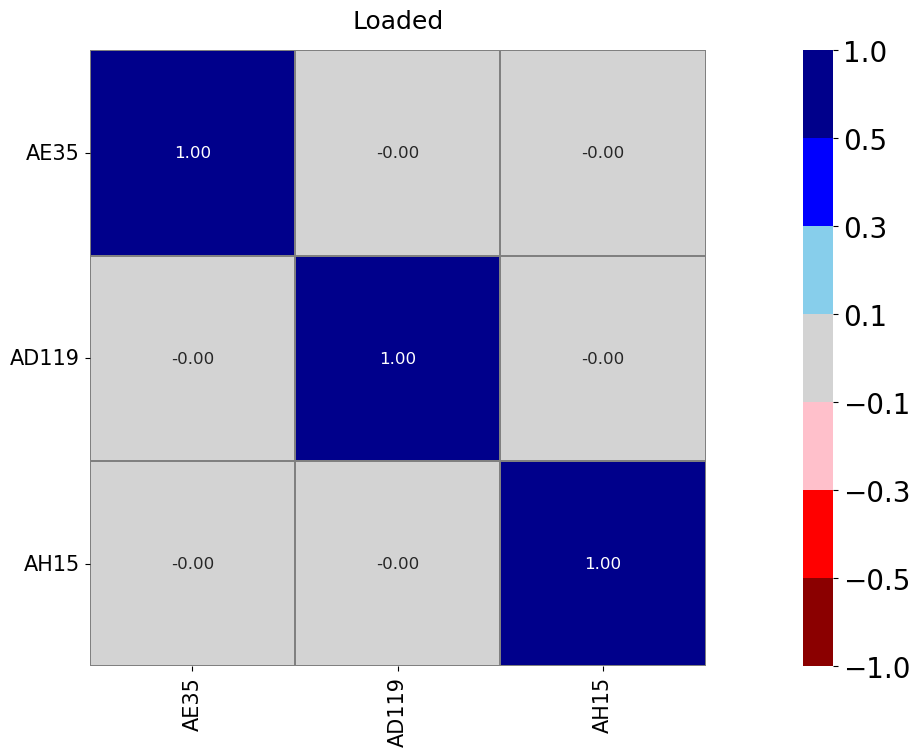

In [45]:
plt.figure(figsize=(25, 8))
cmap = ListedColormap(["darkred", "red", "pink", "lightgray","skyblue", "blue", "darkblue"])
bounds = [-1.0, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1.0]
norm = BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(df_correlation,
                      linecolor="gray",
                      cmap=cmap,
                      norm=norm,
                      square=True,
                      fmt=".2f",
                      linewidths=.01,
                      annot=True,
                      annot_kws={"fontsize":12}
                     )
heatmap.set_title("Loaded", fontdict={"fontsize":18}, pad=16)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.ylabel(None)
plt.xlabel(None)
plt.yticks(fontsize = 15, rotation = 0)
plt.xticks(fontsize = 15, rotation = 90)

corr_pdf = "output/corr.pdf"
plt.savefig(corr_pdf, dpi=600, bbox_inches="tight");